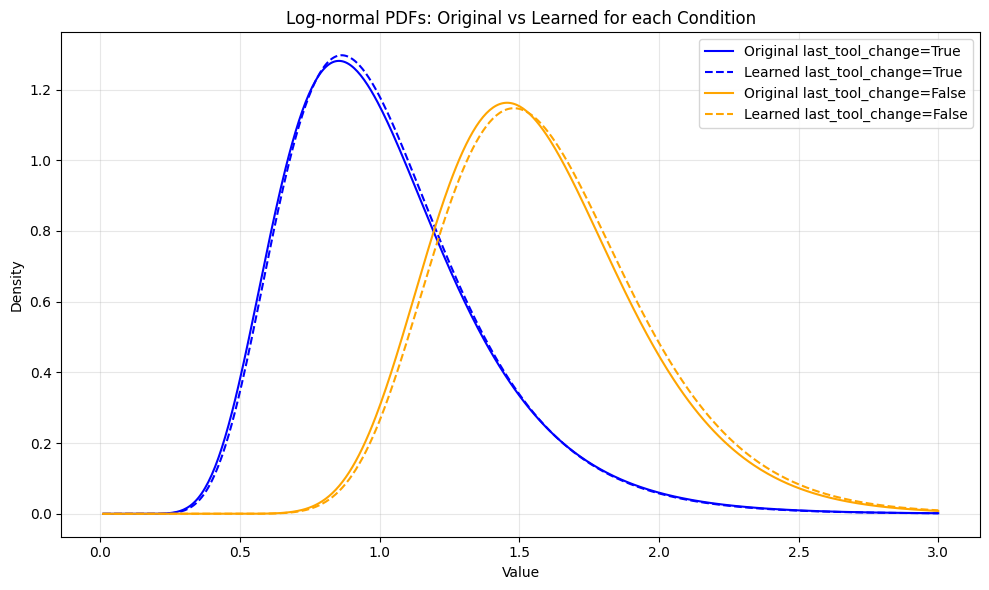

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# --- 1. Define original log-normal distributions for each condition ---
def create_distributions():
    # Example: two conditions (True/False for last_tool_change)
    # These are log-normal parameters (mu, sigma) for each condition
    return {
        ('relative_processing_time_deviation', True): {'mu': -0.03939867427588333, 'sigma': 0.3435984167296766},
        ('relative_processing_time_deviation', False): {'mu': 0.4286333315626201, 'sigma': 0.22946751292240838},
    }

# --- 2. Learn log-normal distributions from data for each condition ---
def learn_distributions(data, target_variable, parent_variables):
    distributions = {}
    relevant_columns = parent_variables + [target_variable]
    filtered_data = data[relevant_columns].dropna()
    parent_combinations = filtered_data[parent_variables].drop_duplicates()
    for _, combination in parent_combinations.iterrows():
        condition = (filtered_data[parent_variables] == combination.values).all(axis=1)
        subset = filtered_data[condition][[target_variable]].values.flatten()
        if len(subset) > 0:
            log_data = np.log(subset)
            mu = np.mean(log_data)
            sigma = np.std(log_data)
            key = (target_variable, combination.values[0])
            distributions[key] = {'mu': mu, 'sigma': sigma}
    return distributions

# --- 3. Load data and learn distributions ---
# For demonstration, generate synthetic data matching the original distributions
np.random.seed(42)
original = create_distributions()
data_rows = []
for cond, params in original.items():
    ltc = cond[1]
    samples = np.random.lognormal(mean=params['mu'], sigma=params['sigma'], size=1000)
    for s in samples:
        data_rows.append({'last_tool_change': ltc, 'relative_processing_time_deviation': s})
data = pd.DataFrame(data_rows)

learned = learn_distributions(data, 'relative_processing_time_deviation', ['last_tool_change'])

# --- 4. Plot all PDFs for each condition ---
x = np.linspace(0.01, 3, 500)
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange']
for idx, cond in enumerate(original.keys()):
    mu_org = original[cond]['mu']
    sigma_org = original[cond]['sigma']
    mu_learn = learned[cond]['mu']
    sigma_learn = learned[cond]['sigma']
    # PDF for original
    pdf_org = lognorm.pdf(x, s=sigma_org, scale=np.exp(mu_org))
    # PDF for learned
    pdf_learn = lognorm.pdf(x, s=sigma_learn, scale=np.exp(mu_learn))
    label_org = f"Original last_tool_change={cond[1]}"
    label_learn = f"Learned last_tool_change={cond[1]}"
    plt.plot(x, pdf_org, color=colors[idx], linestyle='-', label=label_org)
    plt.plot(x, pdf_learn, color=colors[idx], linestyle='--', label=label_learn)

plt.title('Log-normal PDFs: Original vs Learned for each Condition')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Example: Learn and Plot Truncated Normal Distributions
This example demonstrates how to generate, learn, and plot truncated normal distributions for two conditions using `scipy.stats.truncnorm`.

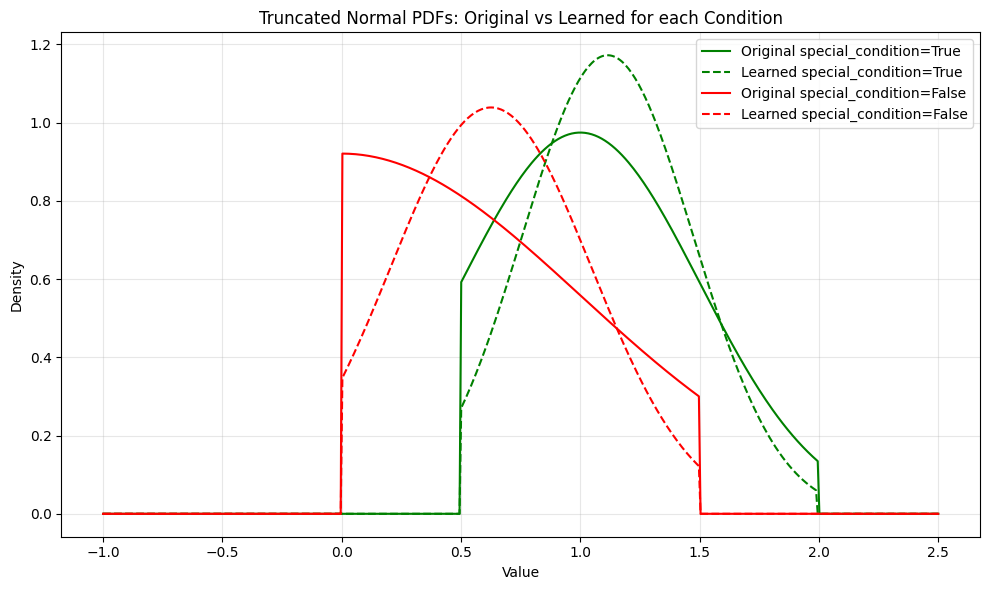

In [14]:
from scipy.stats import truncnorm

# --- 1. Define original truncated normal distributions for each condition ---
def create_truncnorm_distributions():
    # Two conditions (True/False for 'special_condition')
    # Each has (a, b, loc, scale) for truncnorm
    return {
        ('truncnorm_var', True):  {'a': -1, 'b': 2, 'loc': 1.0, 'scale': 0.5},
        ('truncnorm_var', False): {'a': 0, 'b': 1.5, 'loc': 0.0, 'scale': 1.0},
    }

# --- 2. Learn truncated normal parameters from data for each condition ---
def learn_truncnorm_distributions(data, target_variable, parent_variables):
    distributions = {}
    relevant_columns = parent_variables + [target_variable]
    filtered_data = data[relevant_columns].dropna()
    parent_combinations = filtered_data[parent_variables].drop_duplicates()
    for _, combination in parent_combinations.iterrows():
        condition = (filtered_data[parent_variables] == combination.values).all(axis=1)
        subset = filtered_data[condition][[target_variable]].values.flatten()
        if len(subset) > 0:
            # Estimate mean and std for loc/scale, and min/max for a/b
            loc = np.mean(subset)
            scale = np.std(subset)
            a = (np.min(subset) - loc) / scale
            b = (np.max(subset) - loc) / scale
            key = (target_variable, combination.values[0])
            distributions[key] = {'a': a, 'b': b, 'loc': loc, 'scale': scale}
    return distributions

# --- 3. Generate synthetic data for truncated normal ---
np.random.seed(123)
truncnorm_original = create_truncnorm_distributions()
truncnorm_rows = []
for cond, params in truncnorm_original.items():
    sc = cond[1]
    samples = truncnorm.rvs(params['a'], params['b'], loc=params['loc'], scale=params['scale'], size=1000)
    for s in samples:
        truncnorm_rows.append({'special_condition': sc, 'truncnorm_var': s})
truncnorm_data = pd.DataFrame(truncnorm_rows)

truncnorm_learned = learn_truncnorm_distributions(truncnorm_data, 'truncnorm_var', ['special_condition'])

# --- 4. Plot PDFs for each condition ---
x = np.linspace(-1, 2.5, 500)
plt.figure(figsize=(10, 6))
colors = ['green', 'red']
for idx, cond in enumerate(truncnorm_original.keys()):
    org = truncnorm_original[cond]
    learn = truncnorm_learned[cond]
    pdf_org = truncnorm.pdf(x, org['a'], org['b'], loc=org['loc'], scale=org['scale'])
    pdf_learn = truncnorm.pdf(x, learn['a'], learn['b'], loc=learn['loc'], scale=learn['scale'])
    label_org = f"Original special_condition={cond[1]}"
    label_learn = f"Learned special_condition={cond[1]}"
    plt.plot(x, pdf_org, color=colors[idx], linestyle='-', label=label_org)
    plt.plot(x, pdf_learn, color=colors[idx], linestyle='--', label=label_learn)

plt.title('Truncated Normal PDFs: Original vs Learned for each Condition')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()